# Implementation of GRU model on the Drought Prediction

**Predicting Droughts Using Weather & Soil Data in the US**



This notebook is designed to run on Google Colab. It requires at least 25 GB of system RAM and 1.5 GB of GPU RAM, so a T4 GPU with high-RAM runtime is recommended.

You do not need to manually install any datasets. The datasets are downloaded through kaggle when you run the cell code.

If you want to perform full training, simply run all the cells in this notebook.



The best result of the model is with dropout rate of 0.5. You can scroll to the section on dropout rate of 0.5 to see the results.

# Import

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Preprocessing

In [2]:
path = kagglehub.dataset_download("cdminix/us-drought-meteorological-data")

# Load data
soil_df = pd.read_csv(os.path.join(path, "soil_data.csv"))
train_df = pd.read_csv(os.path.join(path, "train_timeseries/train_timeseries.csv"))
val_df = pd.read_csv(os.path.join(path, "validation_timeseries/validation_timeseries.csv"))
test_df = pd.read_csv(os.path.join(path, "test_timeseries/test_timeseries.csv"))

# Define feature lists
weather_features = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN',
                    'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE',
                    'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']
soil_features = ['lat', 'lon', 'elevation', 'slope1', 'slope2', 'slope3', 'slope4', 'slope5',
                 'slope6', 'slope7', 'slope8', 'aspectN', 'aspectE', 'aspectS', 'aspectW',
                 'aspectUnknown', 'WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND',
                 'CULTRF_LAND', 'CULTIR_LAND', 'CULT_LAND', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5',
                 'SQ6', 'SQ7']

100%|██████████| 901M/901M [00:23<00:00, 40.2MB/s]

Extracting files...


In [3]:
#Merge soil data and add seasonal features
for df in [train_df, val_df, test_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(['fips', 'date'], inplace=True)
    day_of_year = df['date'].dt.dayofyear
    df['season_sin'] = np.sin(2 * np.pi * (day_of_year - 1) / 365)
    df['season_cos'] = np.cos(2 * np.pi * (day_of_year - 1) / 365)
train_df = train_df.merge(soil_df, on='fips', how='left')
val_df = val_df.merge(soil_df, on='fips', how='left')
test_df = test_df.merge(soil_df, on='fips', how='left')

In [4]:
# Feature scaling
train_features = train_df[weather_features + soil_features].values
feature_mean = np.nanmean(train_features, axis=0)
feature_std = np.nanstd(train_features, axis=0)
feature_std = np.where(feature_std == 0, 1.0, feature_std)
for df in [train_df, val_df, test_df]:
    df[weather_features + soil_features] = (
        df[weather_features + soil_features].values - feature_mean
    ) / feature_std

dynamic_features = weather_features + ['season_sin', 'season_cos']
static_features = soil_features
target = 'score'

In [5]:
class DroughtDataset(Dataset):
    def __init__(self, df, dynamic_features, static_features, target, seq_length=30):
        self.dynamic_features = dynamic_features
        self.static_features = static_features
        self.target = target
        self.seq_length = seq_length
        self.data = {}
        self.indices = []
        df = df.sort_values(['fips', 'date']).copy()
        for fips, fips_df in df.groupby('fips'):
            X_dynamic = fips_df[dynamic_features].values.astype(np.float32)
            X_static = fips_df[static_features].iloc[0].values.astype(np.float32)
            y = fips_df[target].values.astype(np.float32)
            self.data[fips] = {'X_dynamic': X_dynamic, 'X_static': X_static, 'y': y}
            for i in range(len(fips_df) - seq_length):
                if not np.isnan(y[i + seq_length]):
                    self.indices.append((fips, i))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        fips, start_idx = self.indices[idx]
        X_dynamic = self.data[fips]['X_dynamic'][start_idx:start_idx + self.seq_length]
        X_static = self.data[fips]['X_static']
        y = self.data[fips]['y'][start_idx + self.seq_length]
        return (torch.from_numpy(X_dynamic), torch.from_numpy(X_static), torch.tensor(y, dtype=torch.float32))

# Model

In [7]:
class GRUDroughtModel(nn.Module):
    def __init__(self, dynamic_input_size, static_input_size, hidden_size, num_layers, dropout_rate):
        super(GRUDroughtModel, self).__init__()
        #GRU takes concatenated dynamic and static features
        self.gru = nn.GRU(
            input_size=dynamic_input_size + static_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0  #Dropout only applies if num_layers > 1
        )
        #Final linear layer for prediction
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x_dynamic, x_static):
        batch_size, seq_length, _ = x_dynamic.size()
        #Repeat static features across sequence length
        x_static_repeated = x_static.unsqueeze(1).repeat(1, seq_length, 1)
        #Concatenate dynamic and static features along feature dimension
        x = torch.cat([x_dynamic, x_static_repeated], dim=2)
        #Forward pass through GRU
        _, h_n = self.gru(x)
        #Use the last layer's hidden state
        out = h_n[-1]
        #Final prediction
        out = self.fc(out)
        return out.squeeze(-1)  #Return as (batch,)

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, device, patience=3, scheduler=None):
    train_losses, val_losses, val_maes = [], [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        #Training loop
        model.train()
        train_loss, train_mae, train_samples = 0.0, 0.0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X_dynamic, X_static, y_batch in train_bar:
            X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_dynamic, X_static)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_dynamic.size(0)
            mae = torch.mean(torch.abs(outputs - y_batch))
            train_mae += mae.item() * X_dynamic.size(0)
            train_samples += X_dynamic.size(0)
            train_bar.set_postfix({"Loss": loss.item(), "MAE": mae.item()})

        train_loss /= train_samples
        train_mae /= train_samples
        train_losses.append(train_loss)

        #Validation loop
        model.eval()
        val_loss, val_mae, val_samples = 0.0, 0.0, 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for X_dynamic, X_static, y_batch in val_bar:
                X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
                outputs = model(X_dynamic, X_static)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_dynamic.size(0)
                mae = torch.mean(torch.abs(outputs - y_batch))
                val_mae += mae.item() * X_dynamic.size(0)
                val_samples += X_dynamic.size(0)
                val_bar.set_postfix({"Loss": loss.item(), "MAE": mae.item()})

        val_loss /= val_samples
        val_mae /= val_samples
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        #Checkpointing and Early Stopping
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        torch.save(checkpoint, f"{save_path}_epoch{epoch+1}.pt")
        print(f"Checkpoint saved at {save_path}_epoch{epoch+1}.pt")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(checkpoint, save_path)
            print(f"Best model updated at {save_path}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        #Step the scheduler with the validation loss
        if scheduler:
            scheduler.step(val_loss)

    #Plot losses and MAE
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(val_maes)+1), val_maes, label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Validation MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses, val_maes

# With no dropout rate

In [12]:
#Hyperparameters
seq_length = 90
batch_size = 2048
num_epochs = 10
save_path = 'best_model.pt'
patience = 3  # For early stopping
hidden_size = 64
num_layers = 2
dropout_rate = 0

In [10]:
train_dataset = DroughtDataset(train_df, dynamic_features, static_features, target, seq_length)
val_dataset = DroughtDataset(val_df, dynamic_features, static_features, target, seq_length)
test_dataset = DroughtDataset(test_df, dynamic_features, static_features, target, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 26.94it/s, Loss=1.75, MAE=1.19]


Epoch 1/10, Train Loss: 0.6977, Train MAE: 0.5679, Val Loss: 0.4576, Val MAE: 0.4244
Checkpoint saved at best_model.pt_epoch1.pt
Best model updated at best_model.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 24.18it/s, Loss=2.61, MAE=1.45]


Epoch 2/10, Train Loss: 0.4885, Train MAE: 0.4591, Val Loss: 0.5751, Val MAE: 0.4688
Checkpoint saved at best_model.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 24.75it/s, Loss=1.8, MAE=1.12]


Epoch 3/10, Train Loss: 0.3964, Train MAE: 0.4093, Val Loss: 0.5492, Val MAE: 0.4550
Checkpoint saved at best_model.pt_epoch3.pt


Epoch 4/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 26.98it/s, Loss=2.04, MAE=1.11]


Epoch 4/10, Train Loss: 0.3395, Train MAE: 0.3772, Val Loss: 0.6037, Val MAE: 0.4693
Checkpoint saved at best_model.pt_epoch4.pt
Early stopping triggered after 4 epochs


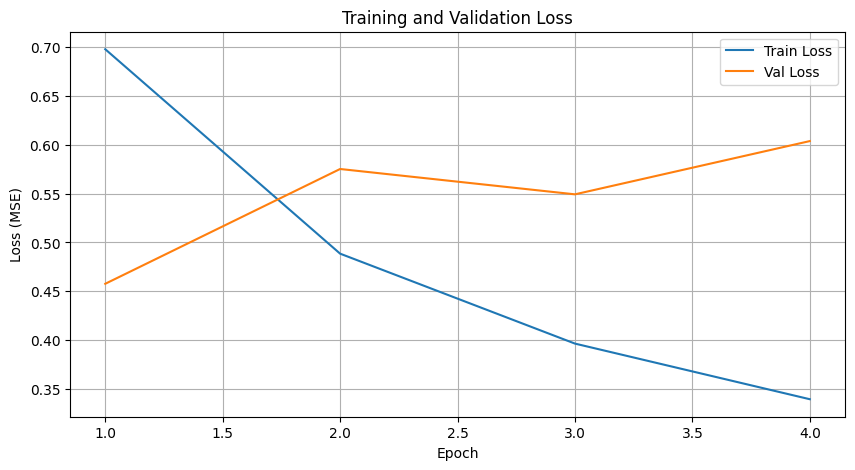

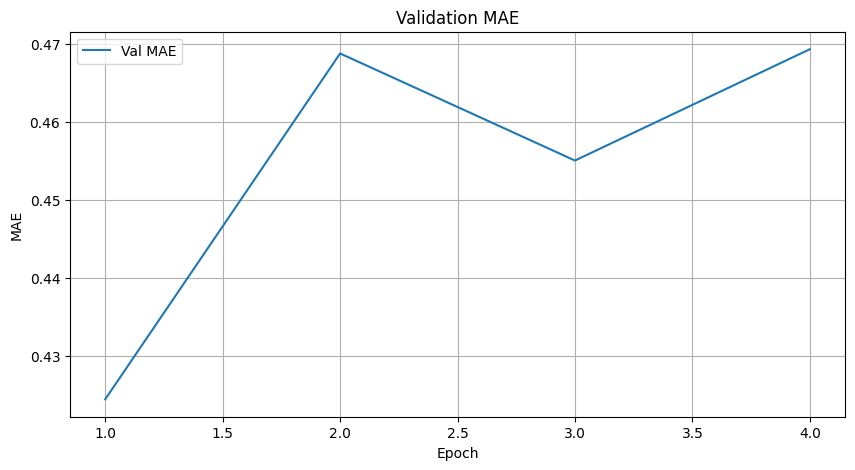

Test Evaluation: 100%|██████████| 140/140 [00:05<00:00, 24.45it/s]

Test Loss: 0.5513, Test MAE: 0.4297


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUDroughtModel(
    dynamic_input_size=len(dynamic_features),
    static_input_size=len(static_features),
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Train the model with the scheduler
model, train_losses, val_losses, val_maes = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, device, patience, scheduler
)

# Evaluate on the test set
model.eval()
test_loss, test_mae, test_samples = 0.0, 0.0, 0
test_predictions = []
with torch.no_grad():
    for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
        X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
        outputs = model(X_dynamic, X_static)
        valid_mask = ~torch.isnan(y_batch)
        if valid_mask.sum() > 0:
            valid_outputs = outputs[valid_mask]
            valid_targets = y_batch[valid_mask]
            loss = criterion(valid_outputs, valid_targets)
            test_loss += loss.item() * valid_mask.sum().item()
            mae = torch.mean(torch.abs(valid_outputs - valid_targets))
            test_mae += mae.item() * valid_mask.sum().item()
            test_samples += valid_mask.sum().item()
        test_predictions.extend(outputs.cpu().numpy())

# Print the final test results
if test_samples > 0:
    test_loss /= test_samples
    test_mae /= test_samples
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
else:
    print("No valid test targets (all NaN), predictions collected.")

# Save the predictions
np.save('test_predictions.npy', np.array(test_predictions))

# with dropout rate 0.2

In [16]:
#Hyperparameters
seq_length = 90
batch_size = 2048
num_epochs = 10
save_path = 'best_model2.pt'
patience = 3  # For early stopping
hidden_size = 64
num_layers = 2
dropout_rate = 0.2

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 26.35it/s, Loss=1.85, MAE=1.22]


Epoch 1/10, Train Loss: 0.6969, Train MAE: 0.5678, Val Loss: 0.5306, Val MAE: 0.4703
Checkpoint saved at best_model2.pt_epoch1.pt
Best model updated at best_model2.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 25.56it/s, Loss=2.01, MAE=1.25]


Epoch 2/10, Train Loss: 0.4866, Train MAE: 0.4571, Val Loss: 0.5388, Val MAE: 0.4575
Checkpoint saved at best_model2.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 24.17it/s, Loss=2.05, MAE=1.24]


Epoch 3/10, Train Loss: 0.4003, Train MAE: 0.4106, Val Loss: 0.5576, Val MAE: 0.4582
Checkpoint saved at best_model2.pt_epoch3.pt


Epoch 4/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 27.34it/s, Loss=2.66, MAE=1.42]


Epoch 4/10, Train Loss: 0.3469, Train MAE: 0.3804, Val Loss: 0.5979, Val MAE: 0.4707
Checkpoint saved at best_model2.pt_epoch4.pt
Early stopping triggered after 4 epochs


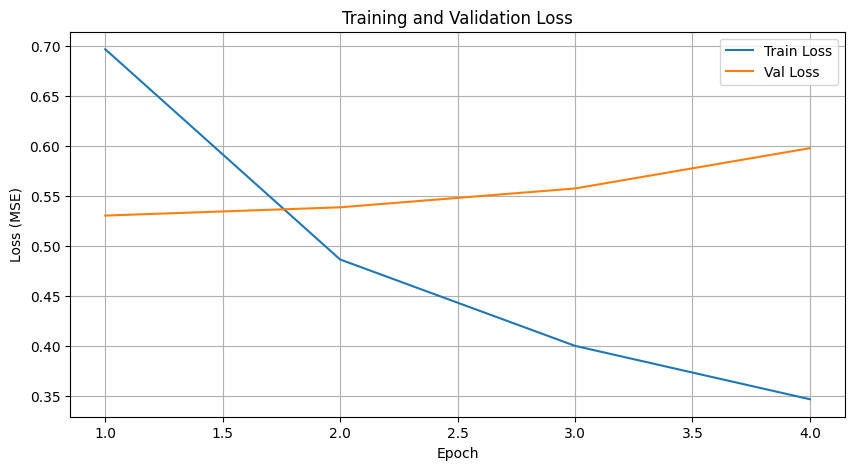

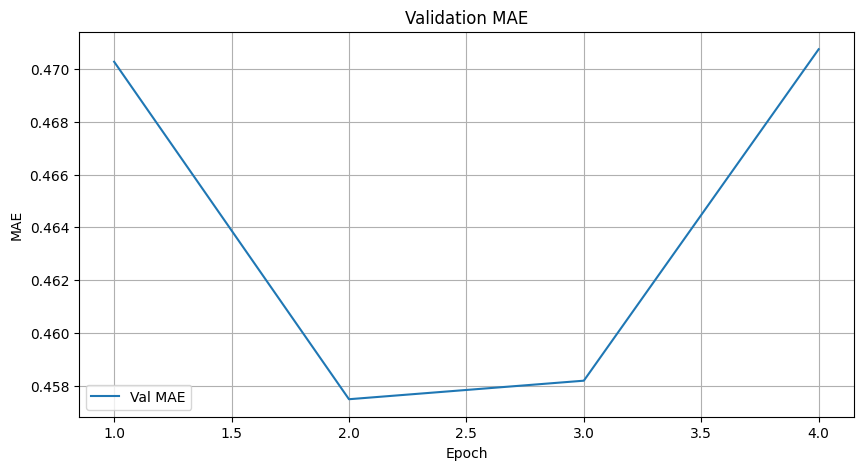

Test Evaluation: 100%|██████████| 140/140 [00:05<00:00, 26.73it/s]

Test Loss: 0.4707, Test MAE: 0.3942


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUDroughtModel(
    dynamic_input_size=len(dynamic_features),
    static_input_size=len(static_features),
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Train the model with the scheduler
model, train_losses, val_losses, val_maes = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, device, patience, scheduler
)

# Evaluate on the test set
model.eval()
test_loss, test_mae, test_samples = 0.0, 0.0, 0
test_predictions = []
with torch.no_grad():
    for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
        X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
        outputs = model(X_dynamic, X_static)
        valid_mask = ~torch.isnan(y_batch)
        if valid_mask.sum() > 0:
            valid_outputs = outputs[valid_mask]
            valid_targets = y_batch[valid_mask]
            loss = criterion(valid_outputs, valid_targets)
            test_loss += loss.item() * valid_mask.sum().item()
            mae = torch.mean(torch.abs(valid_outputs - valid_targets))
            test_mae += mae.item() * valid_mask.sum().item()
            test_samples += valid_mask.sum().item()
        test_predictions.extend(outputs.cpu().numpy())

# Print the final test results
if test_samples > 0:
    test_loss /= test_samples
    test_mae /= test_samples
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
else:
    print("No valid test targets (all NaN), predictions collected.")

# Save the predictions
np.save('test_predictions.npy', np.array(test_predictions))

# higher dropout 0.5

In [18]:
#Hyperparameters
seq_length = 90
batch_size = 2048
num_epochs = 10
save_path = 'best_model2.pt'
patience = 3  # For early stopping
hidden_size = 64
num_layers = 2
dropout_rate = 0.5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUDroughtModel(
    dynamic_input_size=len(dynamic_features),
    static_input_size=len(static_features),
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)

Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 27.65it/s, Loss=1.38, MAE=1.04]


Epoch 1/10, Train Loss: 0.6948, Train MAE: 0.5640, Val Loss: 0.4548, Val MAE: 0.4136
Checkpoint saved at best_model2.pt_epoch1.pt
Best model updated at best_model2.pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 27.07it/s, Loss=1.58, MAE=1.13]


Epoch 2/10, Train Loss: 0.4987, Train MAE: 0.4632, Val Loss: 0.5411, Val MAE: 0.4461
Checkpoint saved at best_model2.pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 26.82it/s, Loss=1.25, MAE=0.981]


Epoch 3/10, Train Loss: 0.4232, Train MAE: 0.4227, Val Loss: 0.5260, Val MAE: 0.4416
Checkpoint saved at best_model2.pt_epoch3.pt


Epoch 4/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 27.10it/s, Loss=0.708, MAE=0.67]


Epoch 4/10, Train Loss: 0.3742, Train MAE: 0.3956, Val Loss: 0.5444, Val MAE: 0.4426
Checkpoint saved at best_model2.pt_epoch4.pt
Early stopping triggered after 4 epochs


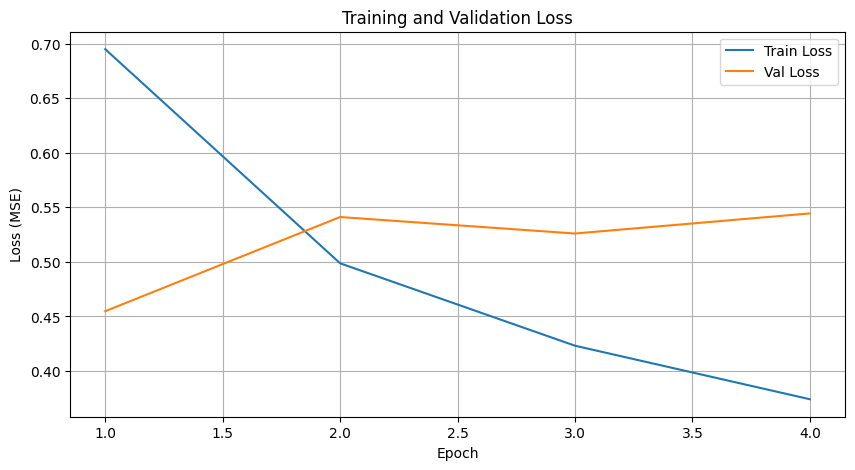

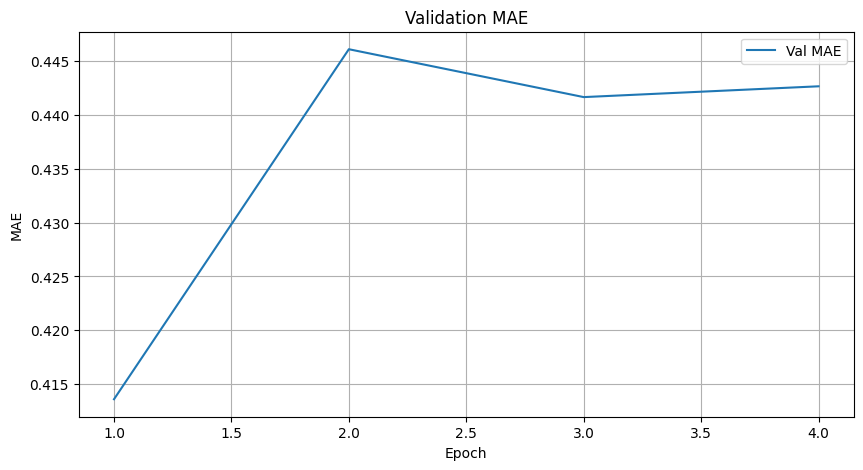

Test Evaluation: 100%|██████████| 140/140 [00:05<00:00, 26.04it/s]

Test Loss: 0.4717, Test MAE: 0.3934


In [19]:
# if you intend to perform evaluation only, don't run this cell and change the save_path to your model parameter
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Train the model with the scheduler
model, train_losses, val_losses, val_maes = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, device, patience, scheduler
)

# Evaluate on the test set
checkpoint_path = save_path
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()
test_loss, test_mae, test_samples = 0.0, 0.0, 0
test_predictions = []
with torch.no_grad():
    for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
        X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
        outputs = model(X_dynamic, X_static)
        valid_mask = ~torch.isnan(y_batch)
        if valid_mask.sum() > 0:
            valid_outputs = outputs[valid_mask]
            valid_targets = y_batch[valid_mask]
            loss = criterion(valid_outputs, valid_targets)
            test_loss += loss.item() * valid_mask.sum().item()
            mae = torch.mean(torch.abs(valid_outputs - valid_targets))
            test_mae += mae.item() * valid_mask.sum().item()
            test_samples += valid_mask.sum().item()
        test_predictions.extend(outputs.cpu().numpy())

# Print the final test results
if test_samples > 0:
    test_loss /= test_samples
    test_mae /= test_samples
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
else:
    print("No valid test targets (all NaN), predictions collected.")

# Save the predictions
np.save('test_predictions.npy', np.array(test_predictions))


In [ ]:
# Run this if you intend to just load the model parameter
checkpoint_path = save_path
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()
test_loss, test_mae, test_samples = 0.0, 0.0, 0
test_predictions = []
with torch.no_grad():
    for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
        X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
        outputs = model(X_dynamic, X_static)
        valid_mask = ~torch.isnan(y_batch)
        if valid_mask.sum() > 0:
            valid_outputs = outputs[valid_mask]
            valid_targets = y_batch[valid_mask]
            loss = criterion(valid_outputs, valid_targets)
            test_loss += loss.item() * valid_mask.sum().item()
            mae = torch.mean(torch.abs(valid_outputs - valid_targets))
            test_mae += mae.item() * valid_mask.sum().item()
            test_samples += valid_mask.sum().item()
        test_predictions.extend(outputs.cpu().numpy())

# Print the final test results
if test_samples > 0:
    test_loss /= test_samples
    test_mae /= test_samples
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
else:
    print("No valid test targets (all NaN), predictions collected.")

# Save the predictions
np.save('test_predictions.npy', np.array(test_predictions))

# with a dropout of 0.4

In [76]:
#Hyperparameters
seq_length = 90
batch_size = 2048
num_epochs = 10
save_path = 'best_model(2.5).pt'
patience = 3  # For early stopping
hidden_size = 64
num_layers = 2
dropout_rate = 0.4

Epoch 1/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 26.23it/s, Loss=2.02, MAE=1.3]


Epoch 1/10, Train Loss: 0.7307, Train MAE: 0.5864, Val Loss: 0.4827, Val MAE: 0.4401
Checkpoint saved at best_model(2.5).pt_epoch1.pt
Best model updated at best_model(2.5).pt


Epoch 2/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 25.65it/s, Loss=1.28, MAE=0.946]


Epoch 2/10, Train Loss: 0.5152, Train MAE: 0.4772, Val Loss: 0.5006, Val MAE: 0.4420
Checkpoint saved at best_model(2.5).pt_epoch2.pt


Epoch 3/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 26.24it/s, Loss=1.53, MAE=1.04]


Epoch 3/10, Train Loss: 0.4345, Train MAE: 0.4354, Val Loss: 0.5238, Val MAE: 0.4373
Checkpoint saved at best_model(2.5).pt_epoch3.pt


Epoch 4/10 [Val]: 100%|██████████| 139/139 [00:05<00:00, 24.57it/s, Loss=3.06, MAE=1.53]


Epoch 4/10, Train Loss: 0.3853, Train MAE: 0.4101, Val Loss: 0.5413, Val MAE: 0.4472
Checkpoint saved at best_model(2.5).pt_epoch4.pt
Early stopping triggered after 4 epochs


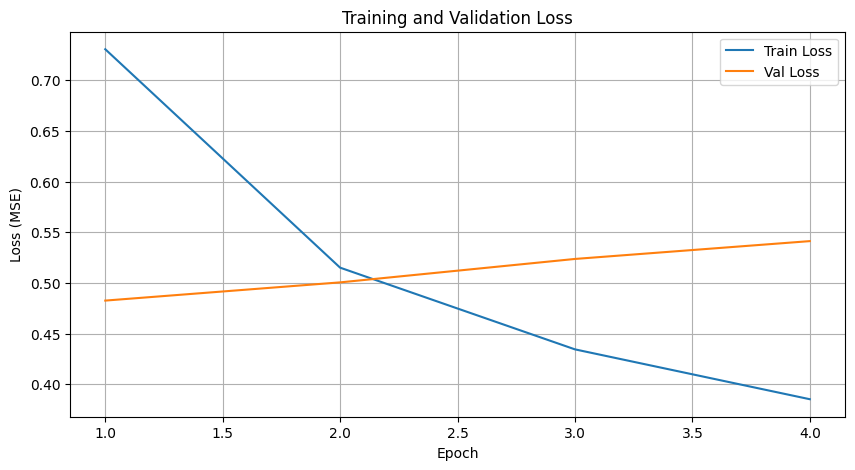

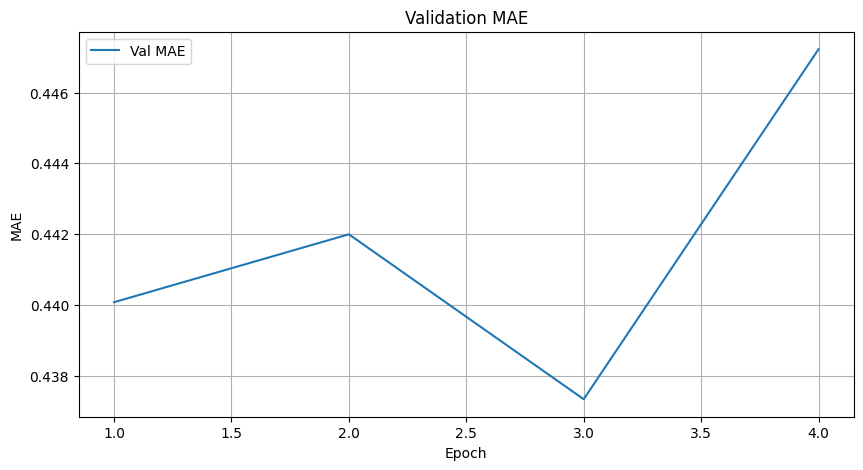

Test Evaluation: 100%|██████████| 140/140 [00:05<00:00, 23.83it/s]

Test Loss: 0.4874, Test MAE: 0.4050


In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUDroughtModel(
    dynamic_input_size=len(dynamic_features),
    static_input_size=len(static_features),
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

# Train the model with the scheduler
model, train_losses, val_losses, val_maes = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, device, patience, scheduler
)

# Evaluate on the test set
model.eval()
test_loss, test_mae, test_samples = 0.0, 0.0, 0
test_predictions = []
with torch.no_grad():
    for X_dynamic, X_static, y_batch in tqdm(test_loader, desc="Test Evaluation"):
        X_dynamic, X_static, y_batch = X_dynamic.to(device), X_static.to(device), y_batch.to(device)
        outputs = model(X_dynamic, X_static)
        valid_mask = ~torch.isnan(y_batch)
        if valid_mask.sum() > 0:
            valid_outputs = outputs[valid_mask]
            valid_targets = y_batch[valid_mask]
            loss = criterion(valid_outputs, valid_targets)
            test_loss += loss.item() * valid_mask.sum().item()
            mae = torch.mean(torch.abs(valid_outputs - valid_targets))
            test_mae += mae.item() * valid_mask.sum().item()
            test_samples += valid_mask.sum().item()
        test_predictions.extend(outputs.cpu().numpy())

# Print the final test results
if test_samples > 0:
    test_loss /= test_samples
    test_mae /= test_samples
    print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
else:
    print("No valid test targets (all NaN), predictions collected.")

# Save the predictions
np.save('test_predictions.npy', np.array(test_predictions))